In [1]:
import numpy as np
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
import time
from sklearn.manifold._locally_linear import barycenter_kneighbors_graph
import os
import sys
sys.path.append("../dataprocess")
import dataprocess as dp

#### Isomap related functions

In [2]:
def performIsomap(X: np.ndarray, k_NN: int, r, transpose_flag: bool):
    """Perform Isomap with scikit-learn

    Args:
        X (np.ndarray): data matrix
        k_NN (int): number of nearest neighbors
        r (int): number of components to keep in the latent space
        transpose_flag (bool): temporal vs spatial arrangement of data

        Returns:
        X_iso (Isomap): Isomap object containing embedded vectors
    """
    start = time.time()
    embedding = Isomap(n_components=r, n_neighbors=k_NN)
    if not transpose_flag:
        """the scikit-learn algorithm by default has a different
        data arrangement than our definition above
         By default it will reduce the size of the columns (temporal e
         mbedding), while our default is to reduce the size of the rows (spatial reduction)
         Note that if the tranpose_flag = True, i.e, we are doing temporal
         reduction, the RAM requirement is very high
         Temporal reduction (transpose_flag = True) needs a much longer
         computational time than spatial reduction (transpose_flag = False)"""
        X = X.T
    X_iso = embedding.fit(X)
    end = time.time()

    print("Time elapsed for Isomap:", end - start, " s")
    print("Shape after embedding:", X_iso.embedding_.shape)

    return X_iso


def inverseTransform(X_test: np.ndarray, X_iso: Isomap, r_max: int, r_step: int,
                     k_NN: int, reg: float, transpose_flag: bool,
):
    """Mapping back to the original space from the latent space and
        calculating reconstruction errors

    Args:
        X_test (np.ndarray): original test data matrix
        X_iso (sklearn.manifold._isomap.Isomap): Isomap object
        r_max (int): max number of modes to keep
        r_step (int): mode number increment for calculating the reconstruction error
        k_NN (int): number of nearest neighbors
        reg (float):  regularization parameter
        transpose_flag (bool): temporal vs spatial arrangement of data

    Returns:
        X_reconstructed (np.ndarray): reconstructed data matrix with r_max modes
        err_rec (np.ndarray): vector containing the reconstruction error for 1 to r_max modes
    """
    err_rec = np.zeros(len(range(1, r_max + 1, r_step)))
    if not transpose_flag:
        # the scikit-learn algorithm by default has a different
        # data arrangement than our definition above
        X_test = X_test.T
    X_test_trans = X_iso.transform(X_test)
    i = 0
    for r in range(1, r_max + 1, r_step):
        # get the first r components of the embedded vectors
        Y = X_test_trans[:, 0:r]
        # calculate the weights for expressing each point in the
        # embedded space as a linear combination of its neighbors
        W = barycenter_kneighbors_graph(Y, n_neighbors=k_NN, reg=reg)
        # reconstruct the data points in the high dimensional space from
        # its neighbors using the weights calculated based on the embedded space
        X_reconstructed = W.dot(X_test)
        # calculate reconstruction error over all snapshots using Frobenius norm
        err_rec[i] = np.linalg.norm(X_test - X_reconstructed) / np.linalg.norm(X_test)
        i += 1
    return X_reconstructed, err_rec

#### Parameters

In [3]:
# Mesh
nx = 227  # X-direction nodes
ny = 120  # Y-direction nodes
# Domain:
Lx = 17.665369  # Lx (Size of the box in x-direction)
Ly = 9.0  # Ly (Size of the box in y-direction)
# Cylinder coordinates:
X_0 = 2.66537  # X coordinate of the center
Y_0 = 4.5  # Y coordinate of the center
r = 0.5  # Cylinder radius

mesh = dp.Mesh(nx, ny, Lx, Ly, X_0, Y_0, r)

# Data path
re = 200
train_input_dir = "../data/modV_train/"
test_input_dir = "../data/modV_test/"
input_filename = f'modV_crop_re{re}.csv'

#### Data pre-processing

In [4]:
""" Read velocity data
  X - velocity module
 rows of X correspond to velocity components at spatial locations
 columns of X correspond to timesteps
     t_1 t_2.  .  t_n
 X = [u  u  .  .  .]  (x_1,y_1)
     [v  v  .  .  .]  (x_1,y_1)
     [w  w  .  .  .]  (x_1,y_1)
     [u  u  .  .  .]  (x_2,y_2)
     [v  v  .  .  .]  (x_2,y_2)
     [w  w  .  .  .]  (x_2,y_2)
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
"""

X_train = dp.read_X_csv(os.path.join(train_input_dir, input_filename))
X_test = dp.read_X_csv(os.path.join(train_input_dir, input_filename))

# Scale data
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)
n, m = X_train.shape
print("Data matrix X is n by m:", n, "x", m, flush=True)

# Erase cylinder from snapshot
X_train_filt = dp.erase_cyl(X_train, mesh)
X_test_filt = dp.erase_cyl(X_test, mesh)

Reading data from: ../data/modV_train/modV_crop_re200.csv
Reading data from: ../data/modV_train/modV_crop_re200.csv
Data matrix X is n by m: 27240 x 1000
Snapshot points without cylinder (27104,)


#### Perform ISOMAP


In [5]:
# k_NN - number of nearest neighbors used for Isomap
# r_max, r_step - number of components to be kept
# in the latent space and for step in post-process
# reg - regularization parameter
k_NN = 25
r_max = 12
r_step = 1
reg = 1e-9

""" transpose_flag - temporal vs spatial arrangement of data
        if True: temporal size of the data will be reduced (leading to spatial modes)
        if False: spatial size of the data will be reduced (NOT leading to spatial modes)"""

transpose_flag = False
X_isomap = performIsomap(X_train_filt, k_NN, r_max, transpose_flag)

#### Post-process

##### Save and plot ISOMAP modes

In [7]:
# save modes in csv and png files
save_flag = False
if save_flag:
    outfile_dir = "modes/"
    modesToSave = r_max
    if modesToSave > X_isomap.embedding_.shape[1]:
        modes = X_isomap.embedding_.shape[1]
        print("Max number of modes is", X_isomap.embedding_.shape[1])
    else:
        dp.save_modes(X_isomap.embedding_, outfile_dir, modesToSave, mesh)

##### Data reconstruction

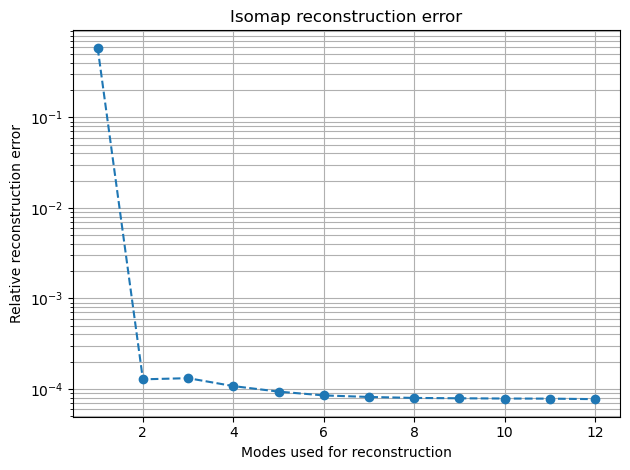

In [8]:
X_reconstructed, err_rec = inverseTransform(
    X_test_filt, X_isomap, r_max, r_step, k_NN, reg, transpose_flag
)
# Save reconstruction errors for further post-processing
np.savetxt("error_rec_Isomap_s.csv", err_rec, delimiter=",")
dp.plot_save_reconst(err_rec, r_max, r_step, "Isomap")